In [33]:
# ===================== 1) IMPORT LIBRARIES =====================
import os
import copy
import random
import math
import numpy as np
import pandas as pd
from tqdm import tqdm

import librosa
import librosa.display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

import matplotlib.pyplot as plt


In [34]:
# ===================== 2) BASIC CONFIG =====================
DATA_DIR = "/kaggle/input/birdclef-2024"   # adjust if needed
TRAIN_AUDIO_DIR = os.path.join(DATA_DIR, "train_audio")
META_PATH = os.path.join(DATA_DIR, "train_metadata.csv")

SR = 32000          # sampling rate
DURATION = 5.0      # seconds to crop/pad each clip
N_MELS = 128
IMG_SIZE_224 = 224
IMG_SIZE_299 = 299

BATCH_SIZE = 32
EPOCHS = 10
PATIENCE = 3

TARGET_CLASSES = 10      # use top-10 classes
TARGET_PER_CLASS = 1000  # oversample target per class for train set

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# Set random seeds for reproducibility (best-effort)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Device: cuda


In [35]:
# ===================== 3) LOAD METADATA & SELECT TOP-10 CLASSES =====================
meta = pd.read_csv(META_PATH)
meta["file_path"] = meta["filename"].apply(lambda x: os.path.join(TRAIN_AUDIO_DIR, x))

# Optionally filter by rating >= 3 (as your original code)
meta = meta[meta["rating"] >= 3].reset_index(drop=True)
print("Metadata after rating filter:", len(meta))

# Choose top-K frequent primary_label classes
topk = meta["primary_label"].value_counts().nlargest(TARGET_CLASSES).index.tolist()
meta_topk = meta[meta["primary_label"].isin(topk)].reset_index(drop=True)
print("Using top classes (count={}):".format(TARGET_CLASSES))
print(meta_topk["primary_label"].value_counts())

# Encode labels
label_encoder = LabelEncoder()
meta_topk["label_idx"] = label_encoder.fit_transform(meta_topk["primary_label"])
num_classes = len(label_encoder.classes_)
print("Num classes (should be TARGET_CLASSES):", num_classes)

# Stratified split train/val
train_df, val_df = train_test_split(
    meta_topk,
    test_size=0.2,
    random_state=SEED,
    stratify=meta_topk["label_idx"]
)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print("Train / Val sizes:", len(train_df), len(val_df))

Metadata after rating filter: 21506
Using top classes (count=10):
primary_label
bkwsti     467
blrwar1    457
comgre     457
bcnher     449
woosan     447
barswa     443
comros     442
eurcoo     440
comkin1    438
graher1    437
Name: count, dtype: int64
Num classes (should be TARGET_CLASSES): 10
Train / Val sizes: 3581 896


In [36]:
# ===================== 4) AUDIO AUGMENTATIONS (apply on waveform) =====================
def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    augmented = y + noise_factor * noise
    return augmented.astype(np.float32)

def time_shift(y, shift_max=0.2):
    shift = int(np.random.uniform(-shift_max, shift_max) * len(y))
    return np.roll(y, shift)

def pitch_shift(y, sr, n_steps=2):
    steps = np.random.uniform(-n_steps, n_steps)
    return librosa.effects.pitch_shift(y, sr, steps)

def time_stretch(y, rate_range=(0.8, 1.25)):
    rate = np.random.uniform(*rate_range)
    try:
        stretched = librosa.effects.time_stretch(y, rate)
        # If stretched shorter/longer, pad/crop to original length later in pipeline
        return stretched
    except Exception:
        return y

# SpecAugment on mel spectrogram (masking)
def spec_augment(mel, num_mask=2, freq_masking_max_percentage=0.15, time_masking_max_percentage=0.20):
    mel = mel.copy()
    num_mel_channels = mel.shape[0]
    num_time_steps = mel.shape[1]

    # Frequency masks
    for _ in range(num_mask):
        freq_percentage = np.random.uniform(0.0, freq_masking_max_percentage)
        num_freqs_to_mask = int(freq_percentage * num_mel_channels)
        f0 = np.random.randint(0, num_mel_channels - num_freqs_to_mask + 1)
        mel[f0:f0 + num_freqs_to_mask, :] = 0

    # Time masks
    for _ in range(num_mask):
        time_percentage = np.random.uniform(0.0, time_masking_max_percentage)
        num_time_to_mask = int(time_percentage * num_time_steps)
        t0 = np.random.randint(0, num_time_steps - num_time_to_mask + 1)
        mel[:, t0:t0 + num_time_to_mask] = 0

    return mel

In [37]:
# ===================== 5) LOAD -> MEL FUNCTION (with safe guards) =====================
def load_mel_spectrogram(path, sr=SR, duration=DURATION, n_mels=N_MELS, apply_spec_augment=False):
    # load audio (handle missing file path)
    if not os.path.exists(path):
        # return silent audio
        y = np.zeros(int(duration * sr), dtype=np.float32)
    else:
        y, sr = librosa.load(path, sr=sr, mono=True)

    max_len = int(duration * sr)
    if len(y) < max_len:
        y = np.pad(y, (0, max_len - len(y)))
    else:
        y = y[:max_len]

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=2048, hop_length=512)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    if apply_spec_augment:
        mel_db = spec_augment(mel_db, num_mask=2)
    return mel_db.astype(np.float32)

# ===================== 6) EXPAND TRAIN DF TO ~TARGET_PER_CLASS (oversample by replacement) =====================
def expand_dataframe_to_target(df, label_col="label_idx", target_per_class=1000):
    rows = []
    grouped = df.groupby(label_col)
    for label, group in grouped:
        current = len(group)
        if current >= target_per_class:
            sampled = group.sample(n=target_per_class, replace=False, random_state=SEED)
        else:
            sampled = group.sample(n=target_per_class, replace=True, random_state=SEED)
        rows.append(sampled)
    expanded = pd.concat(rows).reset_index(drop=True)
    # shuffle
    expanded = expanded.sample(frac=1.0, random_state=SEED).reset_index(drop=True)
    return expanded

print("Expanding training dataframe to ~{} per class...".format(TARGET_PER_CLASS))
train_expanded_df = expand_dataframe_to_target(train_df, target_per_class=TARGET_PER_CLASS)
print("Expanded train size:", len(train_expanded_df), "-> per class approx:", train_expanded_df["label_idx"].value_counts().values[:5])


Expanding training dataframe to ~1000 per class...
Expanded train size: 10000 -> per class approx: [1000 1000 1000 1000 1000]


In [38]:
# ===================== 7) DATASET CLASS (with on-the-fly augmentations) =====================
class BirdSpectrogramDataset(Dataset):
    def __init__(self, df, img_size=IMG_SIZE_224, is_train=True, augment_prob=0.75):
        self.df = df.reset_index(drop=True)
        self.img_size = img_size
        self.is_train = is_train
        self.augment_prob = augment_prob

        # Image transforms: Resize + ToTensor + ImageNet normalize
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)

    def waveform_augment(self, y):
        # apply random audio augmentations with some probabilities
        if random.random() < 0.5:
            y = add_noise(y, noise_factor=np.random.uniform(0.002, 0.01))
        if random.random() < 0.5:
            y = time_shift(y, shift_max=0.2)
        if random.random() < 0.3:
            try:
                y = pitch_shift(y, SR, n_steps=2)
            except Exception:
                pass
        if random.random() < 0.2:
            try:
                y = time_stretch(y)
            except Exception:
                pass
        return y

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["file_path"]
        label = int(row["label_idx"])

        # Load raw waveform and possibly augment it (for train)
        if os.path.exists(path):
            y, sr = librosa.load(path, sr=SR, mono=True)
        else:
            y = np.zeros(int(DURATION * SR), dtype=np.float32)
            sr = SR

        # fix length
        max_len = int(DURATION * sr)
        if len(y) < max_len:
            y = np.pad(y, (0, max_len - len(y)))
        else:
            y = y[:max_len]

        # waveform augmentation
        apply_spec_aug = False
        if self.is_train and random.random() < self.augment_prob:
            y = self.waveform_augment(y)
            apply_spec_aug = True  # apply spec augment sometimes

        # Mel spectrogram
        mel_db = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, n_fft=2048, hop_length=512)
        mel_db = librosa.power_to_db(mel_db, ref=np.max).astype(np.float32)

        # Optional spec augment (on mel)
        if self.is_train and apply_spec_aug and random.random() < 0.7:
            mel_db = spec_augment(mel_db, num_mask=2)

        # normalize to [0,255] then to PIL image
        mel_min, mel_max = mel_db.min(), mel_db.max()
        mel_norm = (mel_db - mel_min) / (mel_max - mel_min + 1e-6)
        mel_img = (mel_norm * 255).astype(np.uint8)
        mel_img = np.stack([mel_img, mel_img, mel_img], axis=-1)  # 3 channels

        pil_img = Image.fromarray(mel_img)
        img_tensor = self.transform(pil_img)

        return img_tensor, label


In [39]:
# ===================== 8) DATALOADERS =====================
train_dataset = BirdSpectrogramDataset(train_expanded_df, img_size=IMG_SIZE_224, is_train=True)
val_dataset   = BirdSpectrogramDataset(val_df, img_size=IMG_SIZE_224, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print("Train loader batches:", len(train_loader), "Val loader batches:", len(val_loader))


Train loader batches: 313 Val loader batches: 28


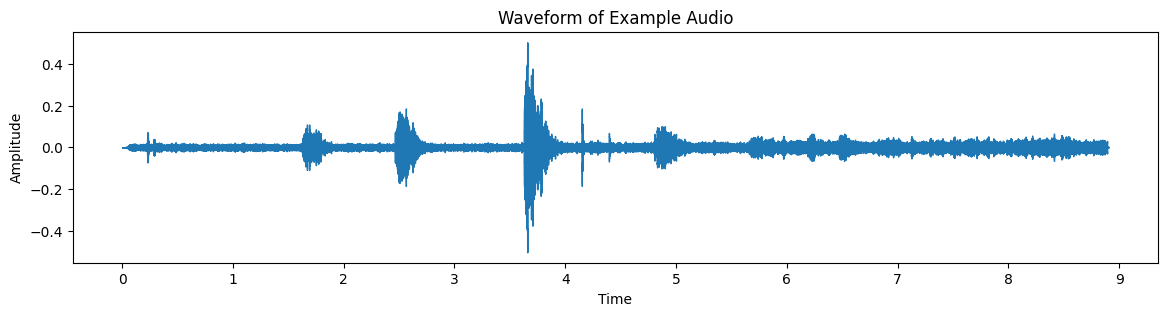

Sample duration (seconds): 8.904


In [67]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Pick one audio file from dataset
sample_path = train_df.iloc[0]["file_path"]

# ===================== LOAD AUDIO =====================
y, sr = librosa.load(sample_path, sr=SR)

plt.figure(figsize=(14, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform of Example Audio")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

print("Sample duration (seconds):", len(y) / sr)


In [72]:
from IPython.display import Audio
Audio(sample_path)


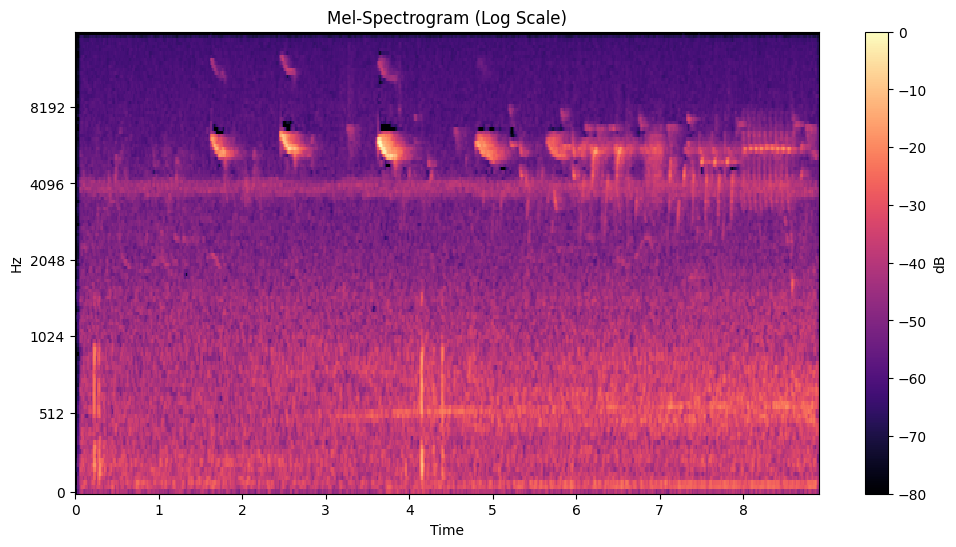

In [68]:
# Generate Mel-Spectrogram
mel = librosa.feature.melspectrogram(
    y=y, sr=sr, n_mels=N_MELS
)
mel_db = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(label="dB")
plt.title("Mel-Spectrogram (Log Scale)")
plt.show()


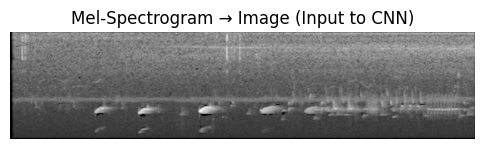

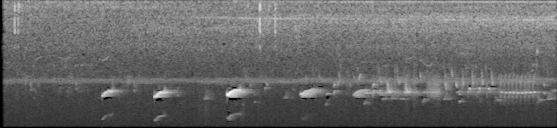

In [69]:
# Normalize 0-255 for image visualization
mel_min, mel_max = mel_db.min(), mel_db.max()
mel_norm = (mel_db - mel_min) / (mel_max - mel_min + 1e-6)
mel_img = (mel_norm * 255).astype(np.uint8)

# Stack to 3 channels
mel_img_rgb = np.stack([mel_img]*3, axis=-1)

plt.figure(figsize=(6,6))
plt.imshow(mel_img_rgb)
plt.title("Mel-Spectrogram → Image (Input to CNN)")
plt.axis("off")
plt.show()

# Show PIL Image (final step)
pil_img = Image.fromarray(mel_img_rgb)
display(pil_img)


In [51]:
# ===================== 9) MODEL FACTORIES (with ImageNet normalization expectation) =====================
class SimpleVGG(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def create_simple_vgg(num_classes):
    return SimpleVGG(num_classes).to(DEVICE)

def create_resnet18(num_classes, pretrained=True):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model.to(DEVICE)

def create_inception_v1(num_classes, pretrained=True):
    """
    Create Inception V1 (GoogLeNet) with pretrained weights and
    KEEP auxiliary logits enabled (required by torchvision).
    """

    # Must stay aux_logits=True when using pretrained=True
    model = models.googlenet(
        weights=models.GoogLeNet_Weights.DEFAULT if pretrained else None,
        aux_logits=True
    )

    # Replace main classifier
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    # Replace aux1 classifier
    if model.aux1 is not None:
        in_features_aux1 = model.aux1.fc2.in_features
        model.aux1.fc2 = nn.Linear(in_features_aux1, num_classes)

    # Replace aux2 classifier
    if model.aux2 is not None:
        in_features_aux2 = model.aux2.fc2.in_features
        model.aux2.fc2 = nn.Linear(in_features_aux2, num_classes)

    return model.to(DEVICE)

def create_mobilenet_v3(num_classes, pretrained=True):
    model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT if pretrained else None)
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
    return model.to(DEVICE)

# ===================== 10) TRAINING LOOP (with early stopping & checkpoint) =====================
def train_one_model(model, train_loader, val_loader, epochs, lr, name="model"):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    best_state = None
    no_improve = 0

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(1, epochs + 1):
        # ---------------- TRAIN ----------------
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"{name} E{epoch}/{epochs} Train"):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)

            # ---- Handle multi-output architectures ----
            if isinstance(outputs, tuple):

                # Case 1: GoogLeNet (Inception V1) → 3 outputs
                if len(outputs) == 3:
                    main_out, aux1_out, aux2_out = outputs

                    loss_main = criterion(main_out, labels)
                    loss_aux1 = criterion(aux1_out, labels)
                    loss_aux2 = criterion(aux2_out, labels)

                    loss = loss_main + 0.3 * loss_aux1 + 0.3 * loss_aux2
                    preds = torch.argmax(main_out, dim=1)

                # Case 2: Inception V3 → 2 outputs
                elif len(outputs) == 2:
                    main_out, aux_out = outputs

                    loss_main = criterion(main_out, labels)
                    loss_aux = criterion(aux_out, labels)

                    loss = loss_main + 0.4 * loss_aux
                    preds = torch.argmax(main_out, dim=1)

            else:
                # Single-output models (ResNet / VGG / MobileNet)
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, dim=1)

            # Backprop
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # ---------------- VALIDATION ----------------
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"{name} E{epoch}/{epochs} Val"):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs)

                if isinstance(outputs, tuple):
                    outputs = outputs[0]  # Only main output used in eval

                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, dim=1)

                val_running_loss += loss.item() * inputs.size(0)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"{name} Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

        # ---------------- EARLY STOPPING ----------------
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_state = copy.deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print(f"{name}: Early stopping.")
                break

    # Restore best weights
    if best_state:
        model.load_state_dict(best_state)

    return model, history


# ===================== 11) EVALUATION FUNCTION (detailed) =====================
def evaluate_model(model, val_loader, name="model", show_cm=True):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"{name} - Evaluation"):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            if isinstance(outputs, tuple):   # Inception special case
                outputs = outputs[0]

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)

    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="macro", zero_division=0
    )

    # AUC
    try:
        y_true_onehot = np.zeros_like(all_probs)
        y_true_onehot[np.arange(len(all_labels)), all_labels] = 1
        auc_val = roc_auc_score(
            y_true_onehot,
            all_probs,
            multi_class="ovr",
            average="macro"
        )
    except:
        auc_val = np.nan

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    if show_cm:
        plt.figure(figsize=(8,8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix - {name}")
        plt.colorbar()
        plt.xlabel("Predicted label index")
        plt.ylabel("True label index")
        plt.tight_layout()
        plt.show()

    return {
        "acc": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc_val,
        "cm": cm,
        "y_true": all_labels,   # <-- IMPORTANT
        "y_prob": all_probs     # <-- IMPORTANT
    }


SimpleVGG E1/2 Val: 100%|██████████| 28/28 [00:32<00:00,  1.17s/it]


SimpleVGG Epoch 1: Train Loss=2.1435, Val Loss=1.4120, Train Acc=0.1980, Val Acc=0.5257


SimpleVGG E2/2 Val: 100%|██████████| 28/28 [00:30<00:00,  1.10s/it]


SimpleVGG Epoch 2: Train Loss=1.3588, Val Loss=1.1275, Train Acc=0.5391, Val Acc=0.6529


SimpleVGG - Evaluation: 100%|██████████| 28/28 [00:31<00:00,  1.11s/it]


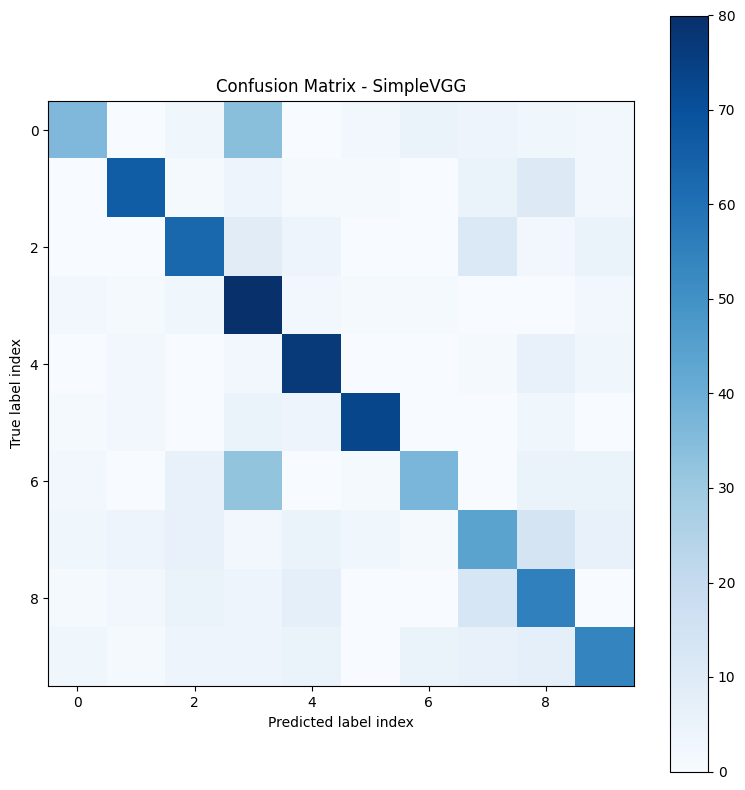

In [9]:
# ===================== 12) TRAIN & EVALUATE (run for the four models) =====================
results = {}
EPOCHS = 2

# 12.1 Simple VGG (from scratch)
vgg = create_simple_vgg(num_classes)
vgg, vgg_hist = train_one_model(vgg, train_loader, val_loader, EPOCHS, 1e-4, "SimpleVGG")

results["SimpleVGG"] = evaluate_model(vgg, val_loader, name="SimpleVGG")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 224MB/s]
ResNet18-TL E1/2 Val: 100%|██████████| 28/28 [00:30<00:00,  1.10s/it]


ResNet18-TL Epoch 1: Train Loss=0.9714, Val Loss=0.5722, Train Acc=0.6746, Val Acc=0.8315


ResNet18-TL E2/2 Val: 100%|██████████| 28/28 [00:30<00:00,  1.10s/it]


ResNet18-TL Epoch 2: Train Loss=0.4857, Val Loss=0.4839, Train Acc=0.8399, Val Acc=0.8661


ResNet18-TL - Evaluation: 100%|██████████| 28/28 [00:33<00:00,  1.20s/it]


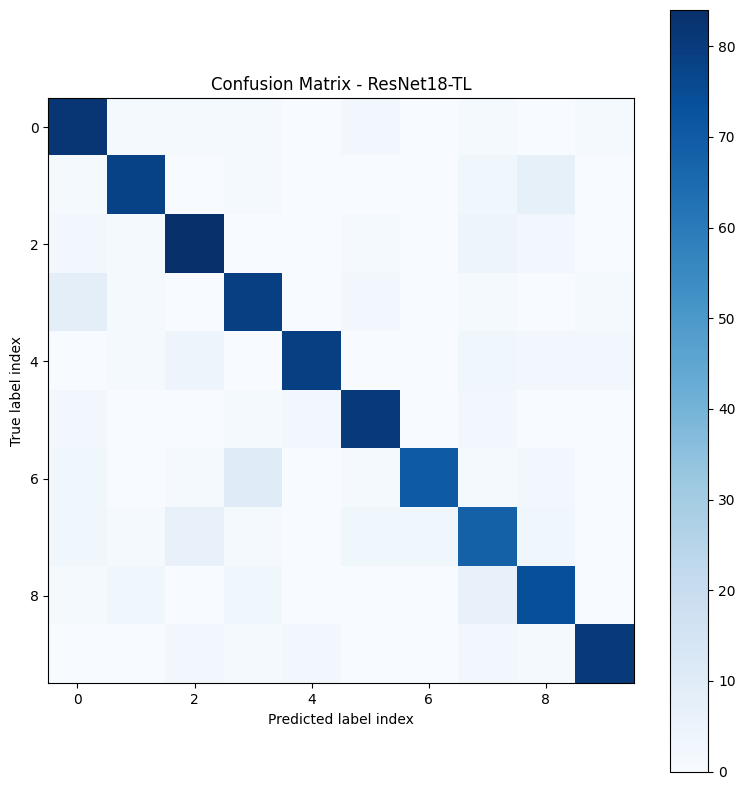

In [10]:
EPOCHS = 2

# 12.2 ResNet18 TL
resnet = create_resnet18(num_classes, pretrained=True)
# Optionally freeze backbone first:
for param in resnet.parameters():
    param.requires_grad = True  # set False to freeze earlier
# resnet = train_one_model(resnet, train_loader, val_loader, epochs=EPOCHS, lr=1e-4, name="ResNet18-TL")
resnet, resnet_hist = train_one_model(resnet, train_loader, val_loader, EPOCHS, 1e-4, "ResNet18-TL")
results["ResNet18-TL"] = evaluate_model(resnet, val_loader, name="ResNet18-TL")


InceptionV1-TL E1/2 Val: 100%|██████████| 28/28 [00:31<00:00,  1.14s/it]


InceptionV1-TL Epoch 1: Train Loss=2.3195, Val Loss=0.6300, Train Acc=0.5730, Val Acc=0.8103


InceptionV1-TL E2/2 Val: 100%|██████████| 28/28 [00:33<00:00,  1.18s/it]


InceptionV1-TL Epoch 2: Train Loss=1.1591, Val Loss=0.5213, Train Acc=0.7966, Val Acc=0.8415


InceptionV1-TL - Evaluation: 100%|██████████| 28/28 [00:32<00:00,  1.17s/it]


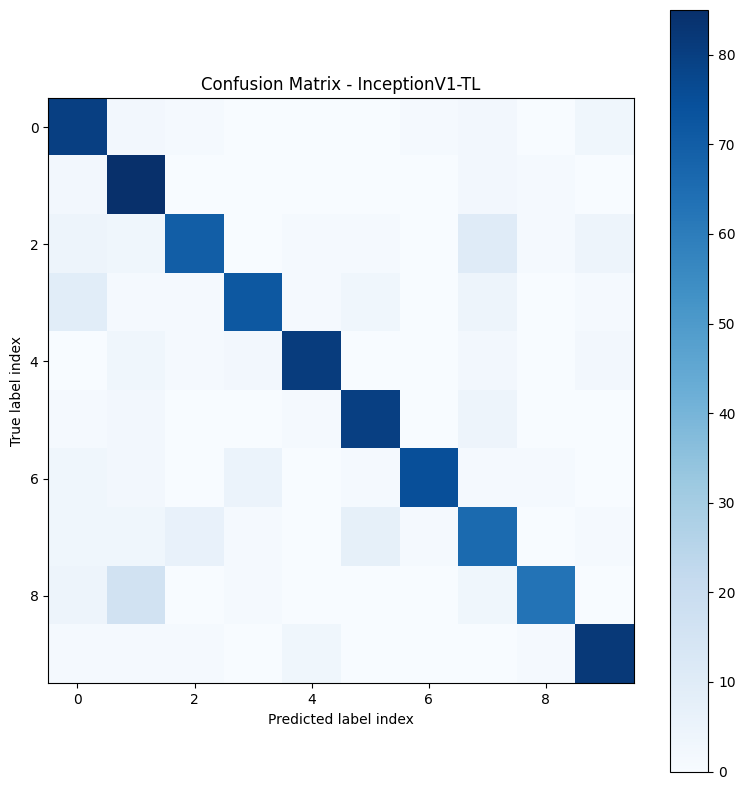

In [52]:
EPOCHS = 2

inception = create_inception_v1(num_classes, pretrained=True)

inception, inception_hist = train_one_model(
    inception,
    train_loader,   
    val_loader,
    epochs=EPOCHS,
    lr=1e-4,
    name="InceptionV1-TL"
)

results["InceptionV1-TL"] = evaluate_model(inception, val_loader, name="InceptionV1-TL")


MobileNetV3-TL E1/2 Val: 100%|██████████| 28/28 [00:32<00:00,  1.17s/it]


MobileNetV3-TL Epoch 1: Train Loss=1.6797, Val Loss=1.1366, Train Acc=0.4220, Val Acc=0.6172


MobileNetV3-TL E2/2 Val: 100%|██████████| 28/28 [00:33<00:00,  1.19s/it]


MobileNetV3-TL Epoch 2: Train Loss=0.9750, Val Loss=0.7192, Train Acc=0.6709, Val Acc=0.7667


MobileNetV3-TL - Evaluation: 100%|██████████| 28/28 [00:32<00:00,  1.18s/it]


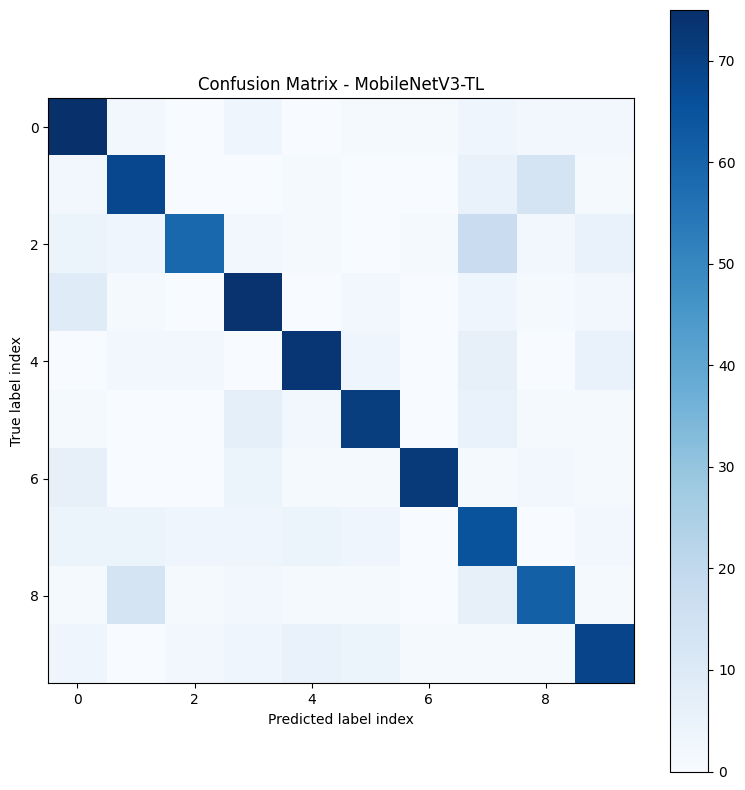

In [53]:
EPOCHS = 2

mobilenet = create_mobilenet_v3(num_classes, pretrained=True)
# mobilenet = train_one_model(mobilenet, train_loader, val_loader, epochs=EPOCHS, lr=1e-4, name="MobileNetV3-TL")

mobilenet, mobilenet_hist = train_one_model(mobilenet, train_loader, val_loader, EPOCHS, 1e-4, "MobileNetV3-TL")
results["MobileNetV3-TL"] = evaluate_model(mobilenet, val_loader, name="MobileNetV3-TL")


In [54]:
print("All results keys:", results.keys())


All results keys: dict_keys(['SimpleVGG', 'ResNet18-TL', 'InceptionV3-TL', 'MobileNetV3-TL', 'InceptionV1-TL'])


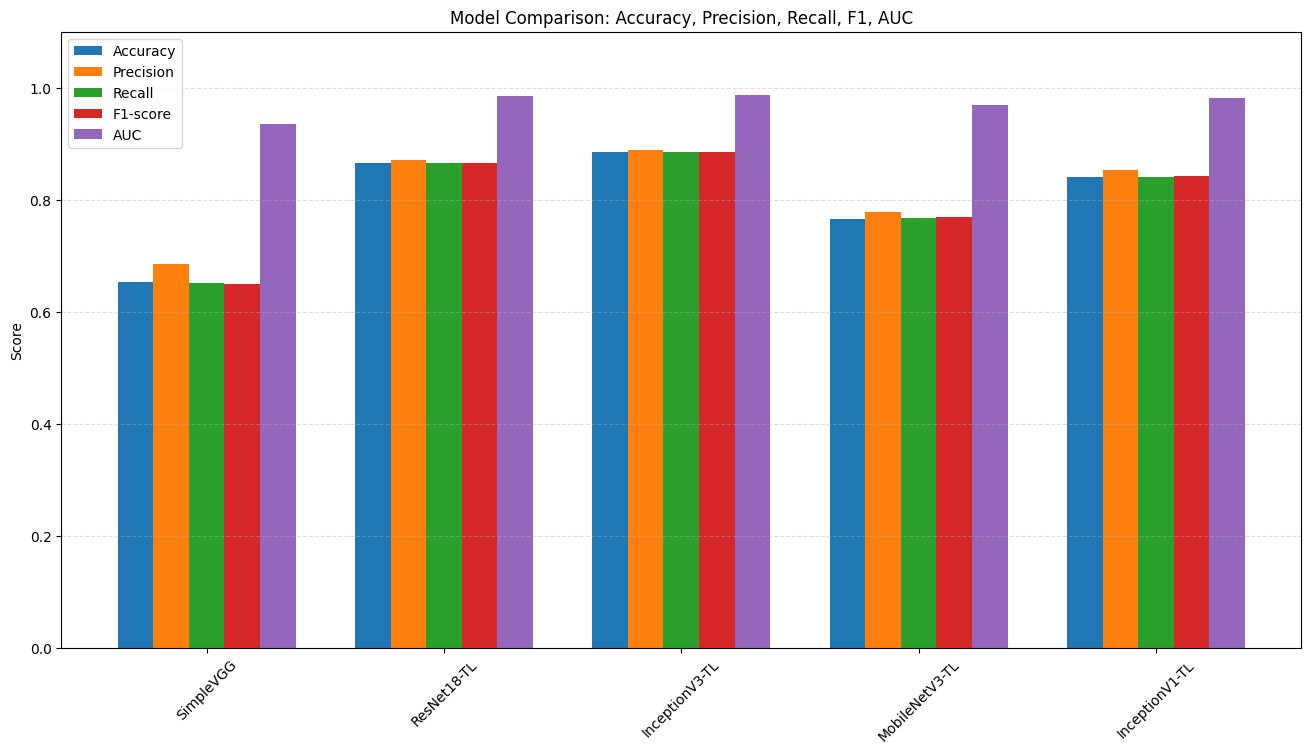

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics from results dict
model_names = list(results.keys())

accuracies  = [results[m]['acc'] for m in model_names]
precisions  = [results[m]['precision'] for m in model_names]
recalls     = [results[m]['recall'] for m in model_names]
f1_scores   = [results[m]['f1'] for m in model_names]
aucs        = [results[m]['auc'] for m in model_names]

# ===================== 1) BAR PLOT FOR ALL METRICS =====================

x = np.arange(len(model_names))
width = 0.15

plt.figure(figsize=(16,8))

plt.bar(x - 2*width, accuracies, width, label='Accuracy')
plt.bar(x - width, precisions, width, label='Precision')
plt.bar(x, recalls, width, label='Recall')
plt.bar(x + width, f1_scores, width, label='F1-score')
plt.bar(x + 2*width, aucs, width, label='AUC')

plt.xticks(x, model_names, rotation=45)
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy, Precision, Recall, F1, AUC")
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()


In [56]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_multiclass_roc(model_name, y_true, y_prob, class_names):
    """
    y_true: ground truth labels (integer encoded)
    y_prob: predicted probabilities (N x C)
    """
    # Binarize labels
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
    n_classes = y_true_bin.shape[1]

    plt.figure(figsize=(10, 8))

    # ROC for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"Class {class_names[i]} (AUC = {roc_auc:.3f})")

    # Macro-Average ROC
    fpr_macro = np.unique(np.concatenate([roc_curve(y_true_bin[:, i], y_prob[:, i])[0] for i in range(n_classes)]))
    tpr_macro = np.zeros_like(fpr_macro)

    for i in range(n_classes):
        fpr_i, tpr_i, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        tpr_macro += np.interp(fpr_macro, fpr_i, tpr_i)

    tpr_macro /= n_classes
    macro_auc = auc(fpr_macro, tpr_macro)
    plt.plot(fpr_macro, tpr_macro, color="black", lw=3, linestyle="--",
             label=f"Macro-average ROC (AUC = {macro_auc:.3f})")

    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"ROC Curve – {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


SimpleVGG - Evaluation: 100%|██████████| 28/28 [00:30<00:00,  1.09s/it]


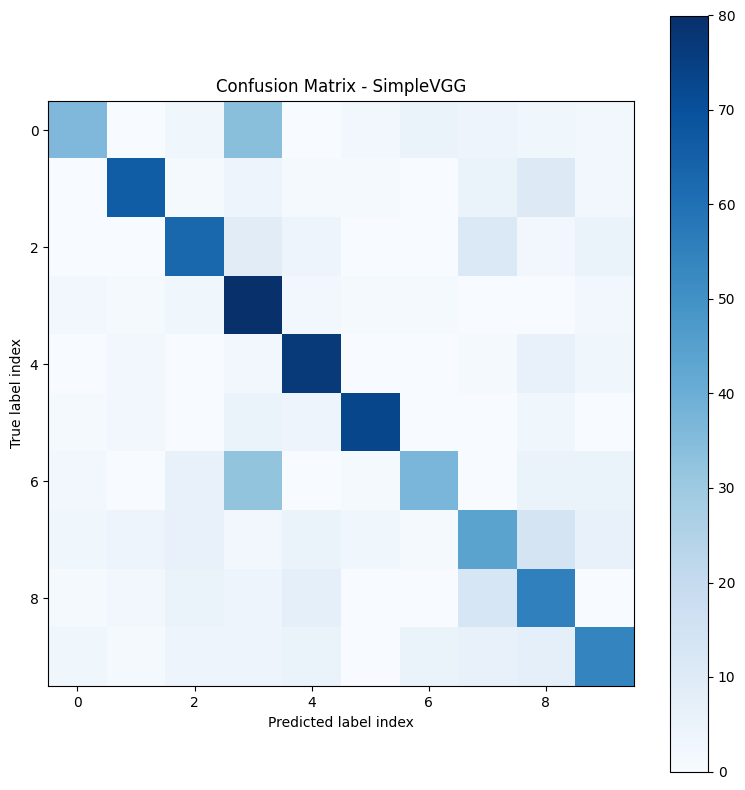

ResNet18-TL - Evaluation: 100%|██████████| 28/28 [00:30<00:00,  1.09s/it]


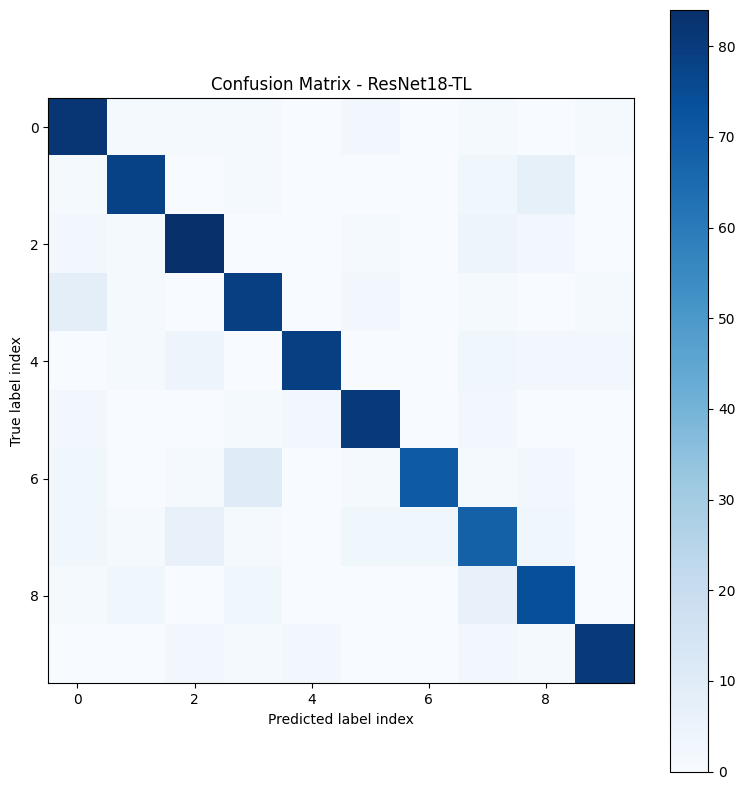

InceptionV3-TL - Evaluation: 100%|██████████| 56/56 [00:31<00:00,  1.76it/s]


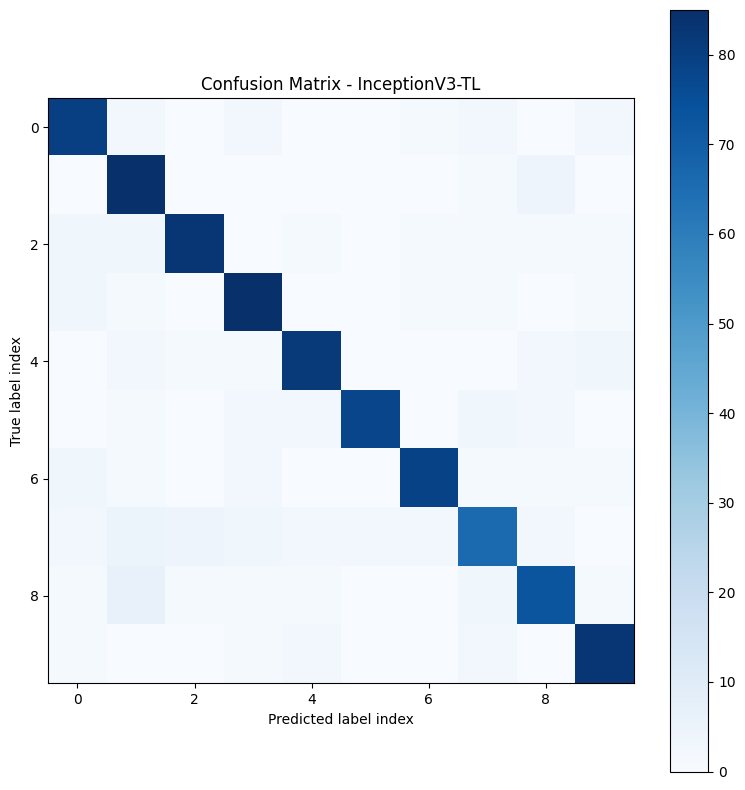

MobileNetV3-TL - Evaluation: 100%|██████████| 28/28 [00:30<00:00,  1.08s/it]


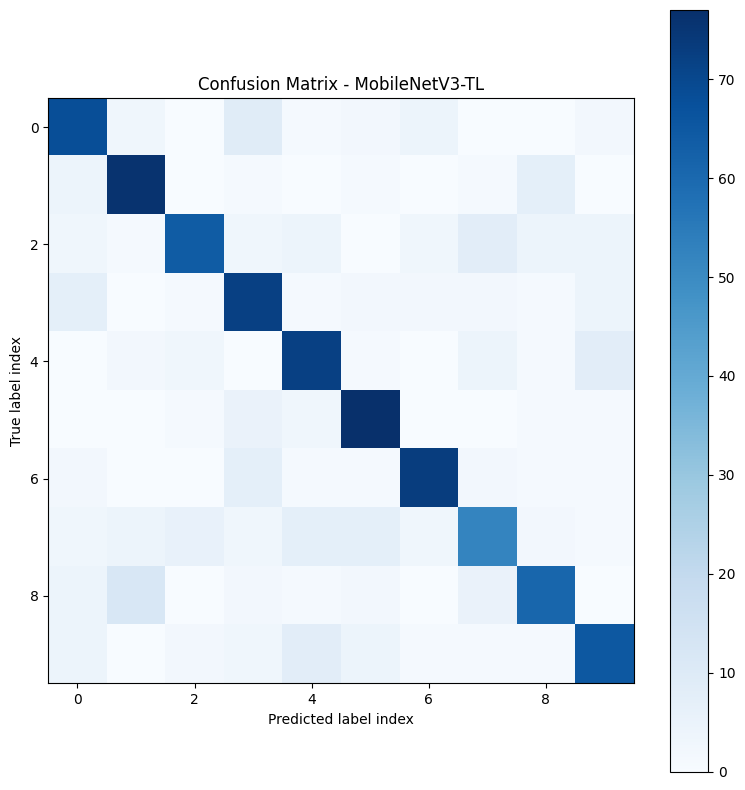

In [16]:
results["SimpleVGG"] = evaluate_model(vgg, val_loader, name="SimpleVGG")
results["ResNet18-TL"] = evaluate_model(resnet, val_loader, name="ResNet18-TL")
results["InceptionV3-TL"] = evaluate_model(inception, val_loader_299, name="InceptionV1-TL")
results["MobileNetV3-TL"] = evaluate_model(mobilenet, val_loader, name="MobileNetV3-TL")


In [57]:
print(results["SimpleVGG"].keys())


dict_keys(['acc', 'precision', 'recall', 'f1', 'auc', 'cm', 'y_true', 'y_prob'])


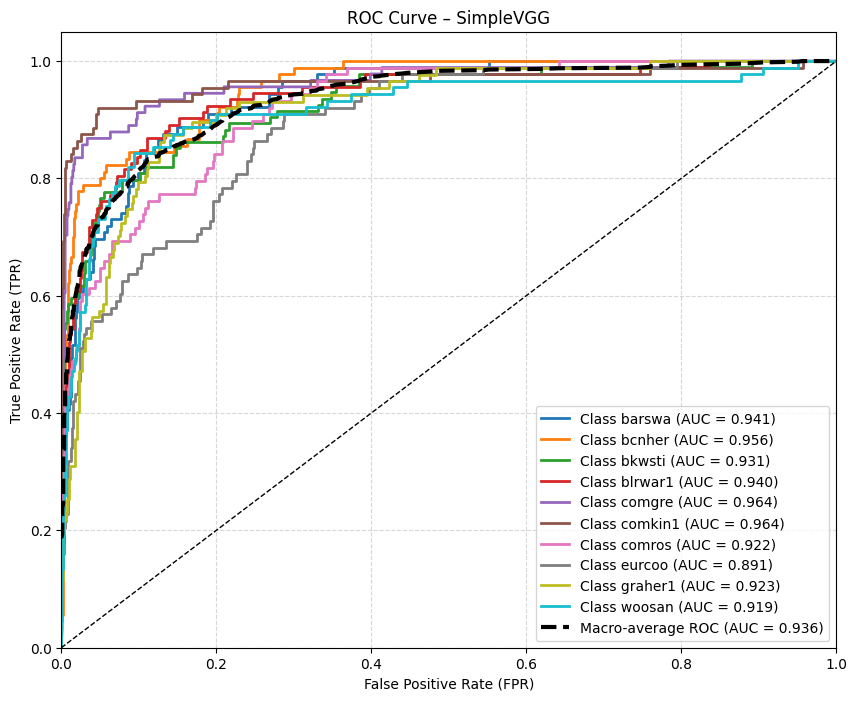

In [58]:
plot_multiclass_roc(
    "SimpleVGG",
    results["SimpleVGG"]["y_true"],
    results["SimpleVGG"]["y_prob"],
    label_encoder.classes_
)


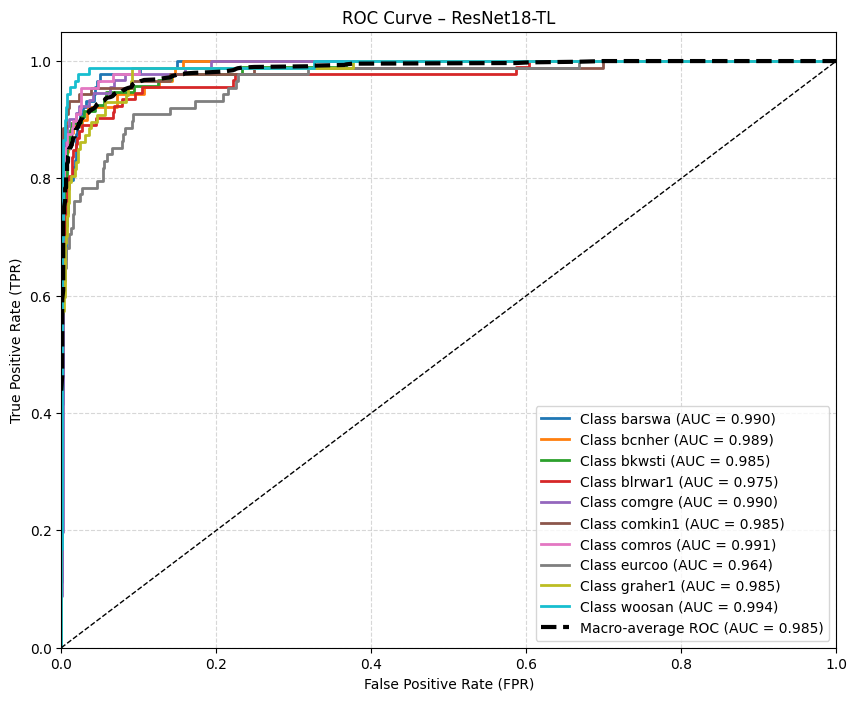

In [59]:
# 2) ResNet
plot_multiclass_roc(
    "ResNet18-TL",
    results["ResNet18-TL"]["y_true"],
    results["ResNet18-TL"]["y_prob"],
    label_encoder.classes_
)



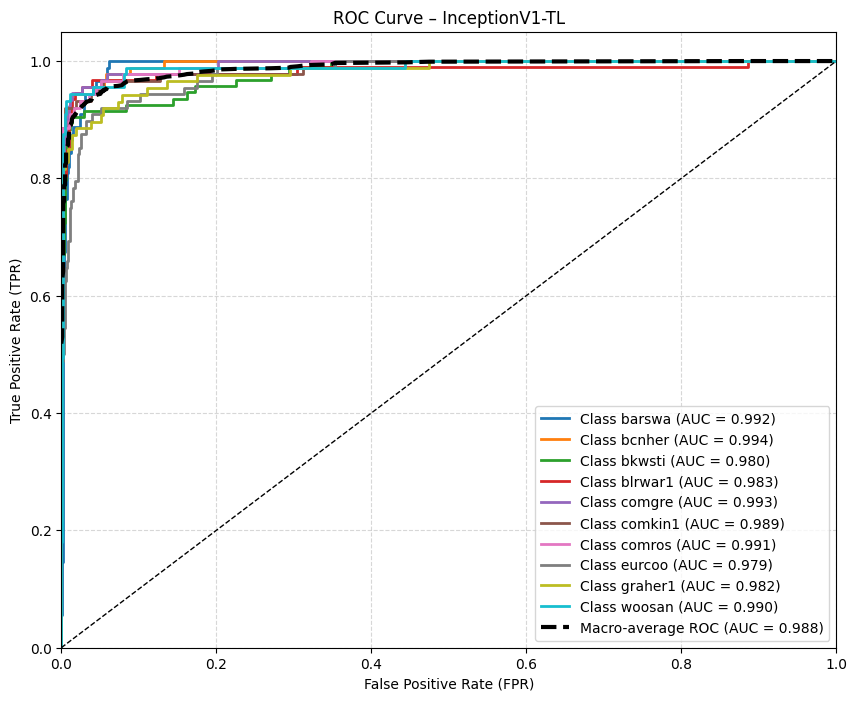

In [60]:
# 3) InceptionV3
plot_multiclass_roc(
    "InceptionV1-TL",
    results["InceptionV3-TL"]["y_true"],
    results["InceptionV3-TL"]["y_prob"],
    label_encoder.classes_
)



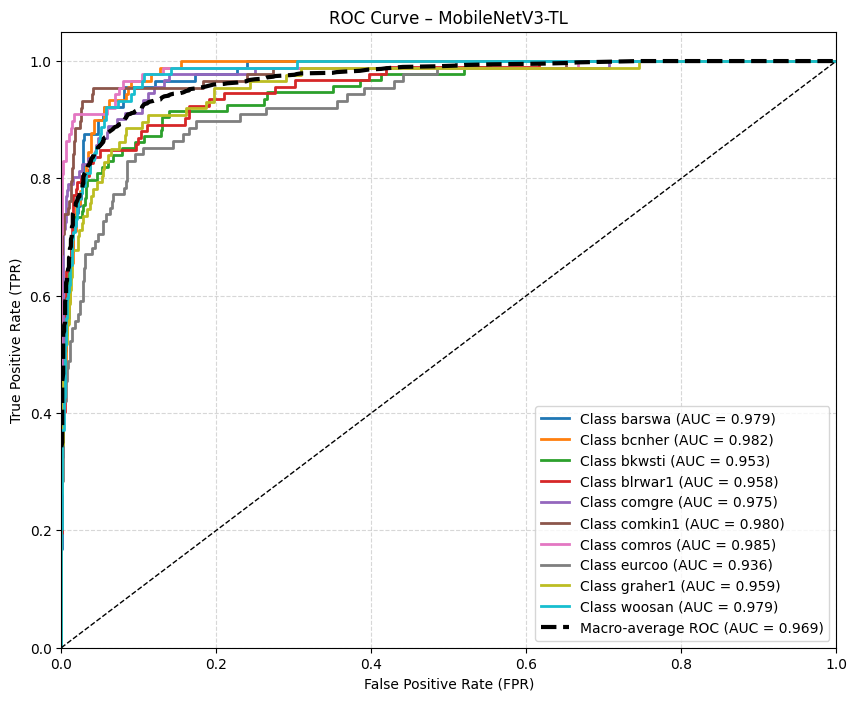

In [61]:
# 4) MobileNetV3
plot_multiclass_roc(
    "MobileNetV3-TL",
    results["MobileNetV3-TL"]["y_true"],
    results["MobileNetV3-TL"]["y_prob"],
    label_encoder.classes_
)

In [62]:
# ===================== 13) Save label encoder mapping & helpers =====================
import json
mapping = {int(i): label for i, label in enumerate(label_encoder.classes_)}
with open("label_mapping.json", "w") as f:
    json.dump(mapping, f)
print("Saved label mapping to label_mapping.json")

# =========

Saved label mapping to label_mapping.json


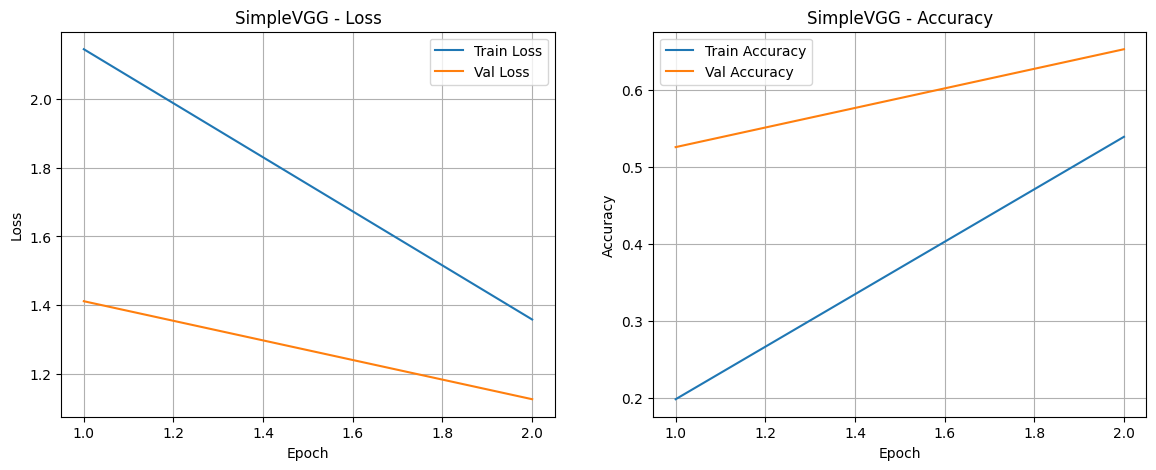

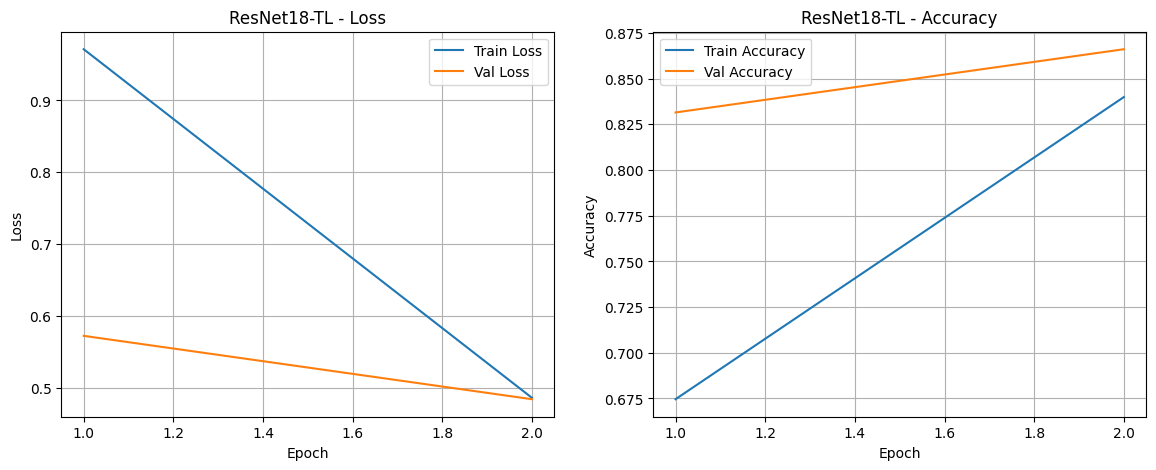

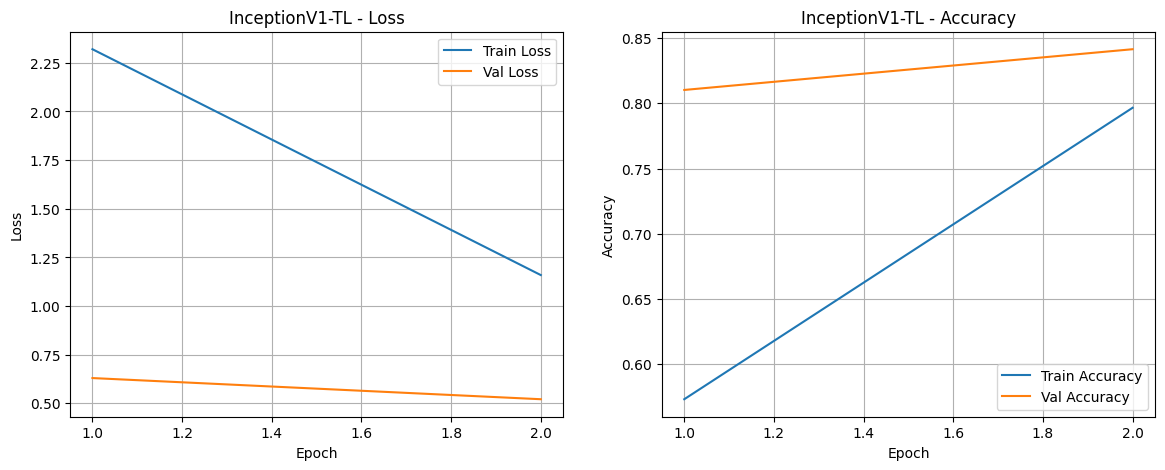

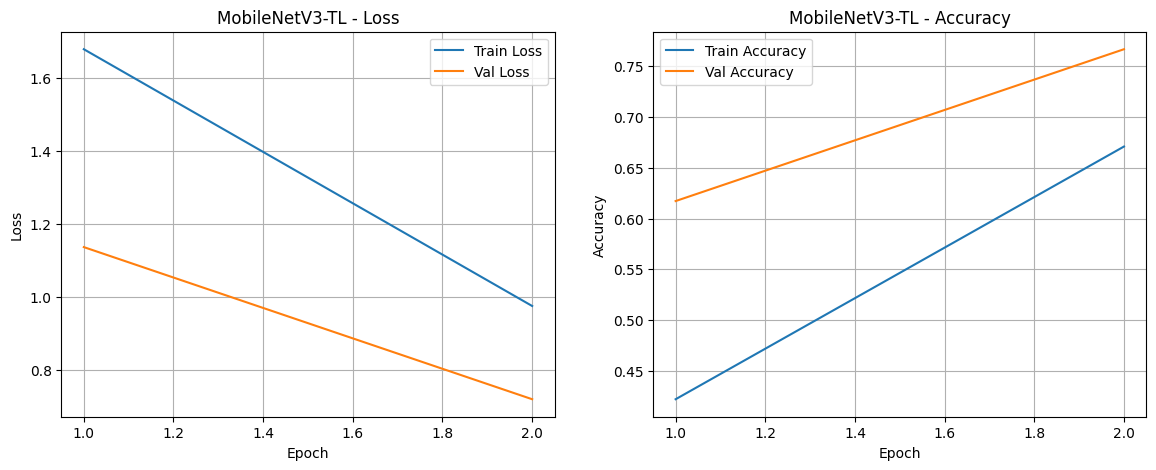

In [63]:
def plot_history(hist, title):
    epochs = range(1, len(hist["train_loss"]) + 1)

    plt.figure(figsize=(14,5))

    # Loss plot
    plt.subplot(1,2,1)
    plt.plot(epochs, hist["train_loss"], label="Train Loss")
    plt.plot(epochs, hist["val_loss"], label="Val Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Accuracy plot
    plt.subplot(1,2,2)
    plt.plot(epochs, hist["train_acc"], label="Train Accuracy")
    plt.plot(epochs, hist["val_acc"], label="Val Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.show()


# Plot for each model
plot_history(vgg_hist, "SimpleVGG")
plot_history(resnet_hist, "ResNet18-TL")
plot_history(inception_hist, "InceptionV1-TL")
plot_history(mobilenet_hist, "MobileNetV3-TL")


In [65]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_all_models_roc(results, class_names):
    plt.figure(figsize=(12, 10))

    for model_name, metrics in results.items():

        y_true = np.array(metrics["y_true"])
        y_prob = np.array(metrics["y_prob"])

        # Binarize labels for multi-class ROC
        y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
        n_classes = y_true_bin.shape[1]

        # Macro ROC
        fpr_macro = np.unique(
            np.concatenate([roc_curve(y_true_bin[:, i], y_prob[:, i])[0] for i in range(n_classes)])
        )
        tpr_macro = np.zeros_like(fpr_macro)

        for i in range(n_classes):
            fpr_i, tpr_i, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
            tpr_macro += np.interp(fpr_macro, fpr_i, tpr_i)

        tpr_macro /= n_classes
        macro_auc = auc(fpr_macro, tpr_macro)

        plt.plot(fpr_macro, tpr_macro, lw=2, label=f"{model_name} (AUC = {macro_auc:.3f})")

    plt.plot([0,1], [0,1], "k--", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison – All Models (Macro-Average)")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.4)
    plt.show()


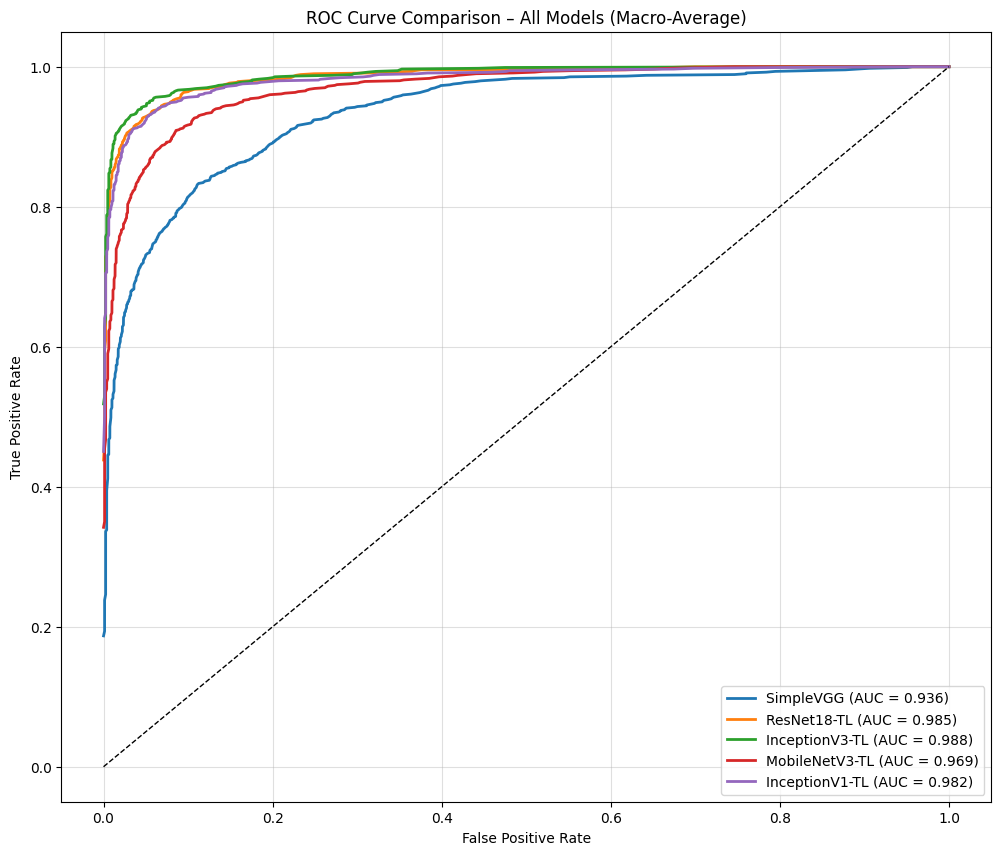

In [66]:
plot_all_models_roc(results, label_encoder.classes_)


In [64]:
# Create folder if not exists
os.makedirs("saved_models", exist_ok=True)

# Save models with .h5 extension (PyTorch-compatible)
torch.save(vgg.state_dict(), "saved_models/SimpleVGG.h5")
torch.save(resnet.state_dict(), "saved_models/ResNet18_TL.h5")
torch.save(inception.state_dict(), "saved_models/InceptionV1_TL.h5")
torch.save(mobilenet.state_dict(), "saved_models/MobileNetV3_TL.h5")

print("Models saved successfully in .h5 format (PyTorch state_dict).")


Models saved successfully in .h5 format (PyTorch state_dict).
